<a href="https://colab.research.google.com/github/Lulu-1121/AIPI-590-XAI-Adversarial-Patches/blob/main/adversarial_patch_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## AIPI 590 Adversarial Patches
### Hongyi Duan (hd162)

**Note: No AI tools used for the assignment**

<br>

## Create a targeted adversarial patch for torchvision ResNet34 on a small ImageNet setup.

In [ ]:
import os, io, math, random, json, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed_everything(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

BASE = Path('.').resolve()
OUT = BASE / 'outputs'
OUT.mkdir(exist_ok=True, parents=True)
print('outputs ->', OUT)

def show_tensor_img(t, title=None):
    t = t.detach().cpu().clamp(0,1)
    if t.ndim == 4:
        t = t[0]
    img = transforms.ToPILImage()(t)
    plt.figure(figsize=(3,3))
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(img)
    plt.show()

def save_tensor_img(t, path):
    t = t.detach().cpu().clamp(0,1)
    if t.ndim == 4:
        t = t[0]
    img = transforms.ToPILImage()(t)
    img.save(path)
    print('saved', path)

device: cpu
outputs -> C:\Users\Leo\111\outputs


## Model and classes
Load torchvision ResNet34 with ImageNet1K weights.

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

def load_model_safe():
    try:
        weights = ResNet34_Weights.IMAGENET1K_V1
        model = resnet34(weights=weights).eval().to(device)
        preprocess = weights.transforms()
        print('Loaded pretrained ResNet34.')
        return model, preprocess
    except Exception as e:
        print('Could not load pretrained weights:', e)
        model = resnet34(weights=None).eval().to(device)
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        print('Using untrained model as fallback.')
        return model, preprocess

model, preprocess = load_model_safe()

def load_imagenet_classes():
    urls = [
        'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt',
        'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    ]
    names = None
    import urllib.request, ssl
    try:
        ctx = ssl.create_default_context()
        ctx.check_hostname = False
        ctx.verify_mode = ssl.CERT_NONE
        txt = None
        for u in urls:
            try:
                with urllib.request.urlopen(u, context=ctx, timeout=10) as r:
                    data = r.read()
                if u.endswith('.txt'):
                    lines = data.decode('utf-8').strip().splitlines()
                    if len(lines) >= 1000:
                        names = [s.strip() for s in lines]
                        break
                else:
                    arr = json.loads(data.decode('utf-8'))
                    if len(arr) >= 1000:
                        names = arr
                        break
            except Exception:
                pass
    except Exception as e:
        names = None
    if names is None:
        names = [f'class_{i}' for i in range(1000)]
        print('Could not fetch class names; using index labels.')
    else:
        print('Loaded ImageNet class names:', len(names))
    return names

IMAGENET_CLASSES = load_imagenet_classes()

@torch.no_grad()
def topk_preds(logits, k=5):
    probs = F.softmax(logits, dim=1)
    p, idx = probs.topk(k, dim=1)
    return p.cpu().numpy(), idx.cpu().numpy()

@torch.no_grad()
def predict(model, x):
    model.eval()
    logits = model(x.to(device))
    return logits


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Leo/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:09<00:00, 9.48MB/s]


Loaded pretrained ResNet34.
Loaded ImageNet class names: 1000


## Target class
I choose a target class by name substring.

In [ ]:
TARGET_KEYWORD = 'toilet tissue'
TARGET_INDEX = None

def resolve_target_index(keyword, override=None):
    if override is not None:
        return int(override)
    key = (keyword or '').lower().strip()
    for i, name in enumerate(IMAGENET_CLASSES):
        if key and key in name.lower():
            print(f'target -> idx={i}, name={IMAGENET_CLASSES[i]}')
            return i

    default_idx = 859 if len(IMAGENET_CLASSES) > 859 else 0
    print(f'keyword not found; fallback idx={default_idx}, name={IMAGENET_CLASSES[default_idx]}')
    return default_idx

TARGET = resolve_target_index(TARGET_KEYWORD, TARGET_INDEX)

target -> idx=999, name=toilet tissue


## Images
I test on a few pictures.

found images: 3
 - sample_0.jpg
 - sample_1.jpg
 - sample_2.jpg
loaded images: 3


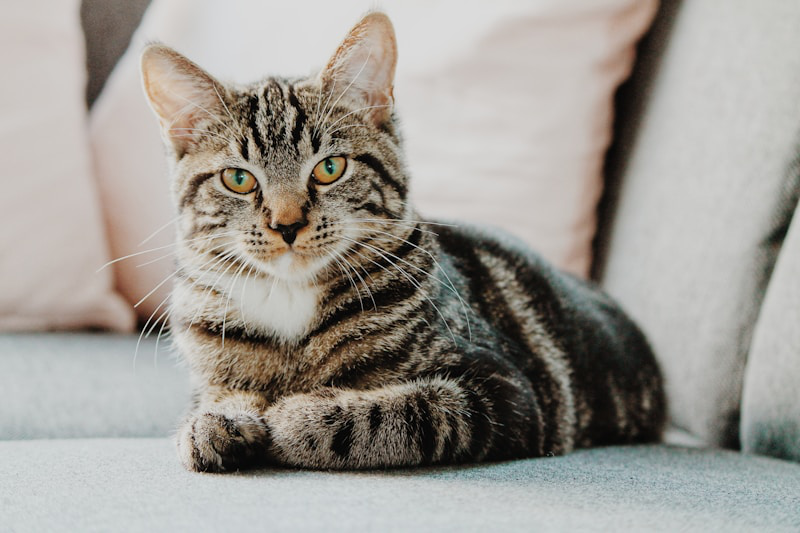

In [ ]:
RAW = BASE / 'raw_images'
RAW.mkdir(exist_ok=True)

def in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

def ask_upload():
    if in_colab():
        from google.colab import files  # type: ignore
        print('Choose 1-5 images to upload (jpg/png).')
        up = files.upload()
        for k, v in up.items():
            with open(RAW / k, 'wb') as f:
                f.write(v)
        return True
    return False

def try_download_samples():
    import urllib.request, ssl
    urls = [
        'https://images.unsplash.com/photo-1518791841217-8f162f1e1131?w=800',  # cat
        'https://images.unsplash.com/photo-1507149833265-60c372daea22?w=800',  # dog
        'https://images.unsplash.com/photo-1542291026-7eec264c27ff?w=800',    # pizza
    ]
    ok = 0
    try:
        ctx = ssl.create_default_context()
        ctx.check_hostname = False
        ctx.verify_mode = ssl.CERT_NONE
        for i,u in enumerate(urls):
            p = RAW / f'sample_{i}.jpg'
            if p.exists():
                ok += 1;
                continue
            with urllib.request.urlopen(u, context=ctx, timeout=10) as r:
                data = r.read()
            with open(p, 'wb') as f:
                f.write(data)
            ok += 1
    except Exception as e:
        pass
    return ok

def fallback_random_images(n=3):
    for i in range(n):
        arr = np.random.rand(256,256,3).astype(np.float32)
        img = Image.fromarray((arr*255).astype(np.uint8))
        img.save(RAW / f'random_{i}.png')

imgs_before = list(RAW.glob('*'))
if len(imgs_before) == 0:
    uploaded = ask_upload()
    if not uploaded:
        d = try_download_samples()
        if d == 0:
            fallback_random_images(3)

all_paths = sorted(list(RAW.glob('*')))
print('found images:', len(all_paths))
for p in all_paths[:5]:
    print(' -', p.name)

def load_images(paths, max_n=8):
    ims = []
    for p in paths[:max_n]:
        try:
            im = Image.open(p).convert('RGB')
            ims.append(im)
        except Exception:
            pass
    return ims

raw_images = load_images(all_paths, max_n=8)
print('loaded images:', len(raw_images))
display(raw_images[0] if len(raw_images)>0 else Image.new('RGB',(224,224),(128,128,128)))

## Baseline prediction

I run the model on the clean images and print top-5. This lets me see what the model thinks before I place any patch.

In [ ]:
def to_batch(ims):
    tensors = []
    for im in ims:
        t = preprocess(im)
        tensors.append(t)
    if len(tensors)==0:
        # fallback dummy
        tensors = [torch.zeros(3,224,224)]
    x = torch.stack(tensors, dim=0)
    return x

x_clean = to_batch(raw_images).to(device)
with torch.no_grad():
    logits = model(x_clean)
probs, idxs = topk_preds(logits, k=5)

for i in range(x_clean.shape[0]):
    print(f'Image {i}:')
    for p, idx in zip(probs[i], idxs[i]):
        name = IMAGENET_CLASSES[idx] if idx < len(IMAGENET_CLASSES) else f'class_{idx}'
        print(f'  {float(p):.4f} -> {idx}: {name}')

Image 0:
  0.4944 -> 281: tabby
  0.4847 -> 282: tiger cat
  0.0133 -> 285: Egyptian cat
  0.0021 -> 478: carton
  0.0012 -> 728: plastic bag
Image 1:
  0.7406 -> 905: window shade
  0.1206 -> 799: sliding door
  0.0227 -> 789: shoji
  0.0212 -> 579: grand piano
  0.0139 -> 904: window screen
Image 2:
  0.9554 -> 770: running shoe
  0.0197 -> 806: sock
  0.0093 -> 788: shoe shop
  0.0053 -> 630: Loafer
  0.0030 -> 502: clog


## Patch

I optimize a square RGB patch (values in [0,1]) and place it randomly on each image. I use a simple differentiable overlay (resize + paste) without rotation to keep it stable.

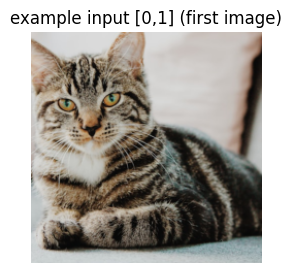

In [ ]:
def place_patch(images01, patch01, frac_min=0.18, frac_max=0.32):
    N, C, H, W = images01.shape
    out = images01.clone()
    for i in range(N):
        s_frac = random.uniform(frac_min, frac_max)
        ph = pw = max(4, int(round(H * s_frac)))

        p = F.interpolate(patch01.unsqueeze(0), size=(ph,pw), mode='bilinear', align_corners=True)[0]

        y = random.randint(0, H - ph)
        x = random.randint(0, W - pw)

        mask = torch.ones_like(p[:1])

        out[i,:,y:y+ph, x:x+pw] = out[i,:,y:y+ph, x:x+pw] * (1-mask) + p * mask
    return out

def denorm(x):

    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
    return x * std + mean

def norm01(x):

    return denorm(x).clamp(0,1)

def batch01_from_raw(ims):

    tensors = []
    basic = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    for im in ims:
        tensors.append(basic(im))
    if len(tensors) == 0:
        tensors = [torch.zeros(3,224,224)]
    return torch.stack(tensors, 0).to(device)

batch01 = batch01_from_raw(raw_images)
show_tensor_img(batch01, 'example input [0,1] (first image)')

## Optimize

I perform targeted optimization: maximize the model probability for my target class after placing the patch. I keep the patch values in [0,1] by clamping after each step.

step 12/120  loss=9.7169
step 24/120  loss=3.4716
step 36/120  loss=3.4544
step 48/120  loss=4.9269
step 60/120  loss=2.2986
step 72/120  loss=1.3878
step 84/120  loss=1.2274
step 96/120  loss=2.7950
step 108/120  loss=0.6928
step 120/120  loss=0.4442


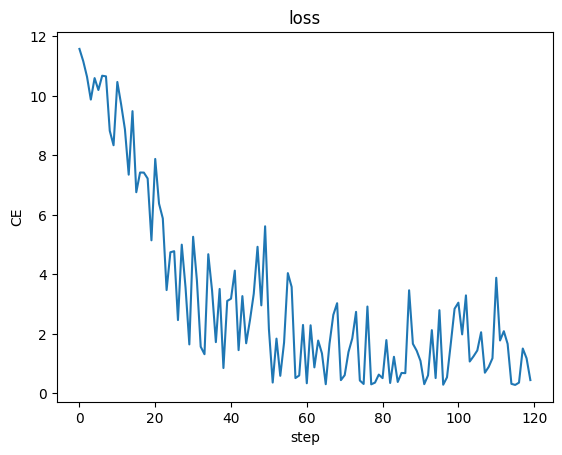

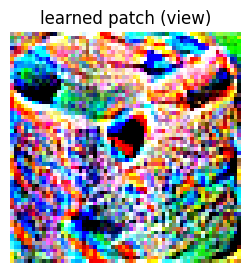

saved C:\Users\Leo\111\outputs\patch_print.png


In [ ]:
target_idx = int(TARGET)
steps = 250 if device.type=='cuda' else 120
lr = 0.08
patch_side = 64

patch = torch.rand(3, patch_side, patch_side, device=device, requires_grad=True)
opt = torch.optim.Adam([patch], lr=lr)

mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

loss_hist = []

for t in range(steps):
    opt.zero_grad()

    imgs01 = batch01.clone()
    adv01 = place_patch(imgs01, patch, 0.18, 0.32)

    adv = (adv01 - mean) / std
    logits = model(adv)

    target = torch.full((adv.shape[0],), target_idx, dtype=torch.long, device=device)
    loss = F.cross_entropy(logits, target) * 1.0
    loss.backward()
    opt.step()
    with torch.no_grad():
        patch.clamp_(0,1)
    loss_hist.append(float(loss.item()))
    if (t+1) % max(1, steps//10) == 0:
        print(f'step {t+1}/{steps}  loss={loss.item():.4f}')

plt.figure(); plt.plot(loss_hist); plt.title('loss'); plt.xlabel('step'); plt.ylabel('CE'); plt.show()

show_tensor_img(patch, title='learned patch (view)')
save_tensor_img(F.interpolate(patch.unsqueeze(0), size=(700,700), mode='nearest'), OUT / 'patch_print.png')


## Evaluate

I place the patch at random positions on each image and report the top-5 predictions. I also compute targeted success rate (whether the target class is ranked top-1).

targeted top-1 success rate over random placements: 0.778


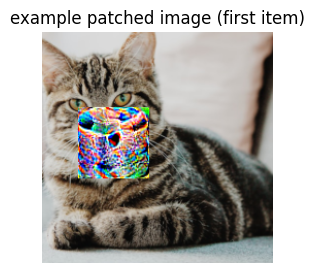

saved C:\Users\Leo\111\outputs\example_patched.png
patched first image top-5:
  0.5306 -> 700: paper towel
  0.3070 -> 999: toilet tissue
  0.0738 -> 285: Egyptian cat
  0.0385 -> 281: tabby
  0.0280 -> 728: plastic bag


In [ ]:
@torch.no_grad()
def eval_with_patch(images01, patch, trials=8):
    N = images01.shape[0]
    top1_hits = 0
    all_reports = []
    for r in range(trials):
        adv01 = place_patch(images01, patch, 0.2, 0.32)
        adv = (adv01 - mean) / std
        logits = model(adv)
        probs, idxs = topk_preds(logits, k=5)
        for i in range(N):
            hit = (idxs[i,0] == target_idx)
            if hit: top1_hits += 1
            all_reports.append((i, probs[i], idxs[i]))
    sr = top1_hits / (N * trials + 1e-9)
    return sr, all_reports

sr, reports = eval_with_patch(batch01, patch, trials=6)
print(f'targeted top-1 success rate over random placements: {sr:.3f}')

adv01 = place_patch(batch01, patch, 0.24, 0.32)
show_tensor_img(adv01, title='example patched image (first item)')
save_tensor_img(adv01, OUT / 'example_patched.png')

with torch.no_grad():
    adv = (adv01 - mean) / std
    logits = model(adv)
probs, idxs = topk_preds(logits, k=5)
i = 0
print('patched first image top-5:')
for p, idx in zip(probs[i], idxs[i]):
    name = IMAGENET_CLASSES[idx] if idx < len(IMAGENET_CLASSES) else f'class_{idx}'
    print(f'  {float(p):.4f} -> {idx}: {name}')

## Sticker disguise

I turn the patch into a circular sticker by applying a round alpha mask, then place it. I also export a print sheet for this version. This is my creative extension.

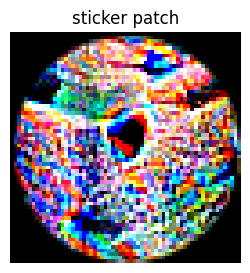

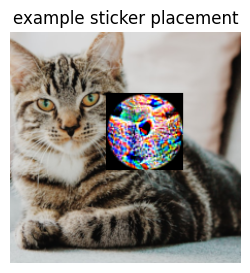

saved C:\Users\Leo\111\outputs\sticker_patch_print.png


In [ ]:
def circular_mask_like(p):
    _, H, W = p.shape
    y, x = torch.meshgrid(torch.arange(H, device=p.device), torch.arange(W, device=p.device), indexing='ij')
    y = (y - H/2) / (H/2)
    x = (x - W/2) / (W/2)
    r = torch.sqrt(x*x + y*y)
    m = (r <= 1.0).float().unsqueeze(0)  # [1,H,W]

    band = (r>0.95) & (r<=1.0)
    m[0, band] = (1.0 - (r[band]-0.95)/0.05).float()
    return m

@torch.no_grad()
def apply_mask(p, m):
    return p * m + (0.0) * (1-m)

mask_circ = circular_mask_like(patch)
sticker = apply_mask(patch, mask_circ).clamp(0,1)
show_tensor_img(sticker, title='sticker patch')

adv01_sticker = place_patch(batch01, sticker, 0.24, 0.34)
show_tensor_img(adv01_sticker, title='example sticker placement')
save_tensor_img(F.interpolate(sticker.unsqueeze(0), size=(700,700), mode='nearest'), OUT / 'sticker_patch_print.png')


## Combine two patches

I train a second small patch for another target and paste both. This tests what happens when two objectives mix.

target -> idx=954, name=banana
second patch step 18/90
second patch step 36/90
second patch step 54/90
second patch step 72/90
second patch step 90/90


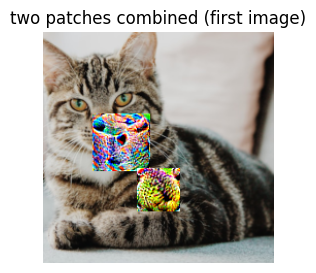

saved C:\Users\Leo\111\outputs\combo_patched.png


In [ ]:
SECOND_TARGET_KEYWORD = 'banana'
SECOND_TARGET_INDEX = None
SECOND_TARGET = resolve_target_index(SECOND_TARGET_KEYWORD, SECOND_TARGET_INDEX)

steps2 = 160 if device.type=='cuda' else 90
patch2 = torch.rand(3, 48, 48, device=device, requires_grad=True)
opt2 = torch.optim.Adam([patch2], lr=0.08)
for t in range(steps2):
    opt2.zero_grad()
    imgs01 = batch01.clone()
    adv01 = place_patch(imgs01, patch2, 0.12, 0.22)
    adv = (adv01 - mean) / std
    logits = model(adv)
    target2 = torch.full((adv.shape[0],), int(SECOND_TARGET), dtype=torch.long, device=device)
    loss = F.cross_entropy(logits, target2)
    loss.backward()
    opt2.step()
    with torch.no_grad():
        patch2.clamp_(0,1)
    if (t+1) % max(1, steps2//5) == 0:
        print(f'second patch step {t+1}/{steps2}')

def place_two(images01, p1, p2):
    tmp = place_patch(images01, p1, 0.20, 0.28)
    out = place_patch(tmp, p2, 0.12, 0.20)
    return out

adv01_combo = place_two(batch01, patch, patch2)
show_tensor_img(adv01_combo, title='two patches combined (first image)')
save_tensor_img(adv01_combo, OUT / 'combo_patched.png')


## Secret message with a series of patches

I put a row of small patches and encode a short message by rotation: 0°=0, 90°=1. I save a sheet to print. Anyone who knows the rule can read the bits from left to right. This is just for fun and to meet the requirement.

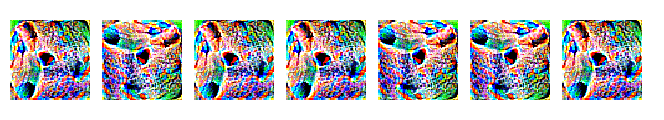

saved C:\Users\Leo\111\outputs\secret_message_sheet.png


In [ ]:
msg = '1011001'  # I can change this to any bit string
tile = F.interpolate(patch.unsqueeze(0), size=(80,80), mode='nearest')[0].detach().cpu()
tiles = []
for b in msg:
    im = transforms.ToPILImage()(tile)
    if b == '1':
        im = im.rotate(90, expand=True).resize((80,80))
    tiles.append(im)

# compose a row
W = 20 + len(tiles)*(80+12)
H = 120
sheet = Image.new('RGB', (W, H), (255,255,255))
x = 10
for im in tiles:
    sheet.paste(im, (x, 20))
    x += 80 + 12

sheet_path = OUT / 'secret_message_sheet.png'
sheet.save(sheet_path)
display(sheet)
print('saved', sheet_path)


In [ ]:
print('Artifacts saved in:', OUT)
print('\n'.join([p.name for p in OUT.glob('*')]))

assert (OUT / 'patch_print.png').exists(), 'patch_print.png missing'
print('ready to go ✅')

Artifacts saved in: C:\Users\Leo\111\outputs
combo_patched.png
example_patched.png
patch_print.png
secret_message_sheet.png
sticker_patch_print.png
ready to go ✅
